<a href="https://colab.research.google.com/github/DAbbottPersonal/PM_china/blob/main/PM_china.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of PM2.5 values in China

## Importing the dataset

There are several PM2.5 readings for each dataset. Store all of them as a dictionary of numpy arrays for now.

In [572]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
dataset = pd.read_csv('/content/ShanghaiPM20100101_20151231.csv')
features = ['No', 
            'year', 
            'month', 
            'day', 
            'hour', 
            'season', 
            'DEWP', 
            'HUMI',
            'PRES', 
            'TEMP', 
            'cbwd', 
            'Iws', 
            'precipitation', 
            'Iprec']
# If True, this will try linear, polynomial, SVR, and RF regressions
# thus will also add some run time If False it will just run the
# RF regression (best so far).
try_all_regressions = False
X = dataset.loc[:, features].values
y = {}
for i in dataset.columns:
  if 'PM_' in i:
    y[i] = dataset.loc[:, i].values

## Plotting

Create some basic plots to get a broad understanding of the dataset and its trends.

### The different PM2.5 measurements.

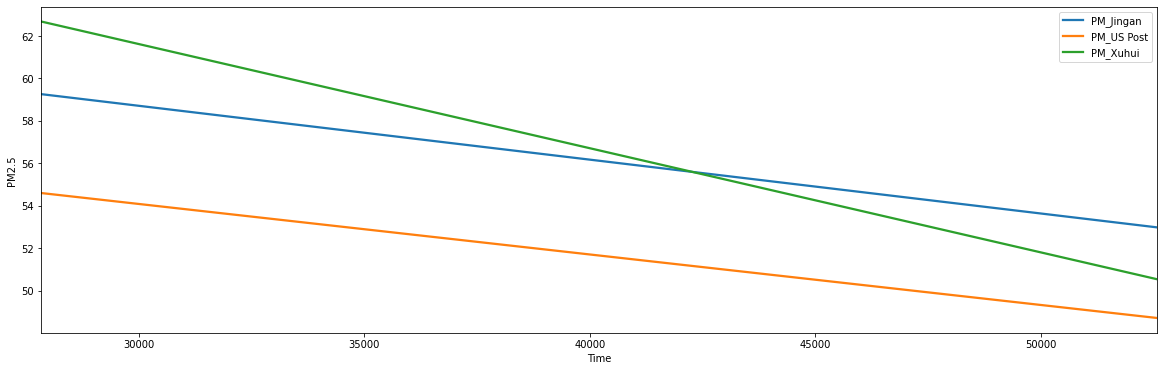

In [573]:
import seaborn as sns
plotting_dict = y
plotting_dict['time'] = (np.array(range(0,len(y['PM_US Post']))))
plotting_df = pd.DataFrame.from_dict(plotting_dict, orient='index')
plotting_df = plotting_df.transpose()
plotting_df = plotting_df[plotting_df['time']>27826]
fig, ax = plt.subplots(figsize=(20, 6))
for key in y.keys():
  if key == 'time':
    continue
  sns.regplot(x='time', y=key, data=plotting_df, fit_reg=True, ci=None, ax=ax, label=key, scatter = False)
ax.set(ylabel='PM2.5', xlabel='Time')
ax.legend()
plt.show()

There are some differences (albeit minor) in the measurements of PM2.5 for the different measurement sites. Given that US Post has the most data and is present in every city, it will be used going forward.

### Plotting the Features

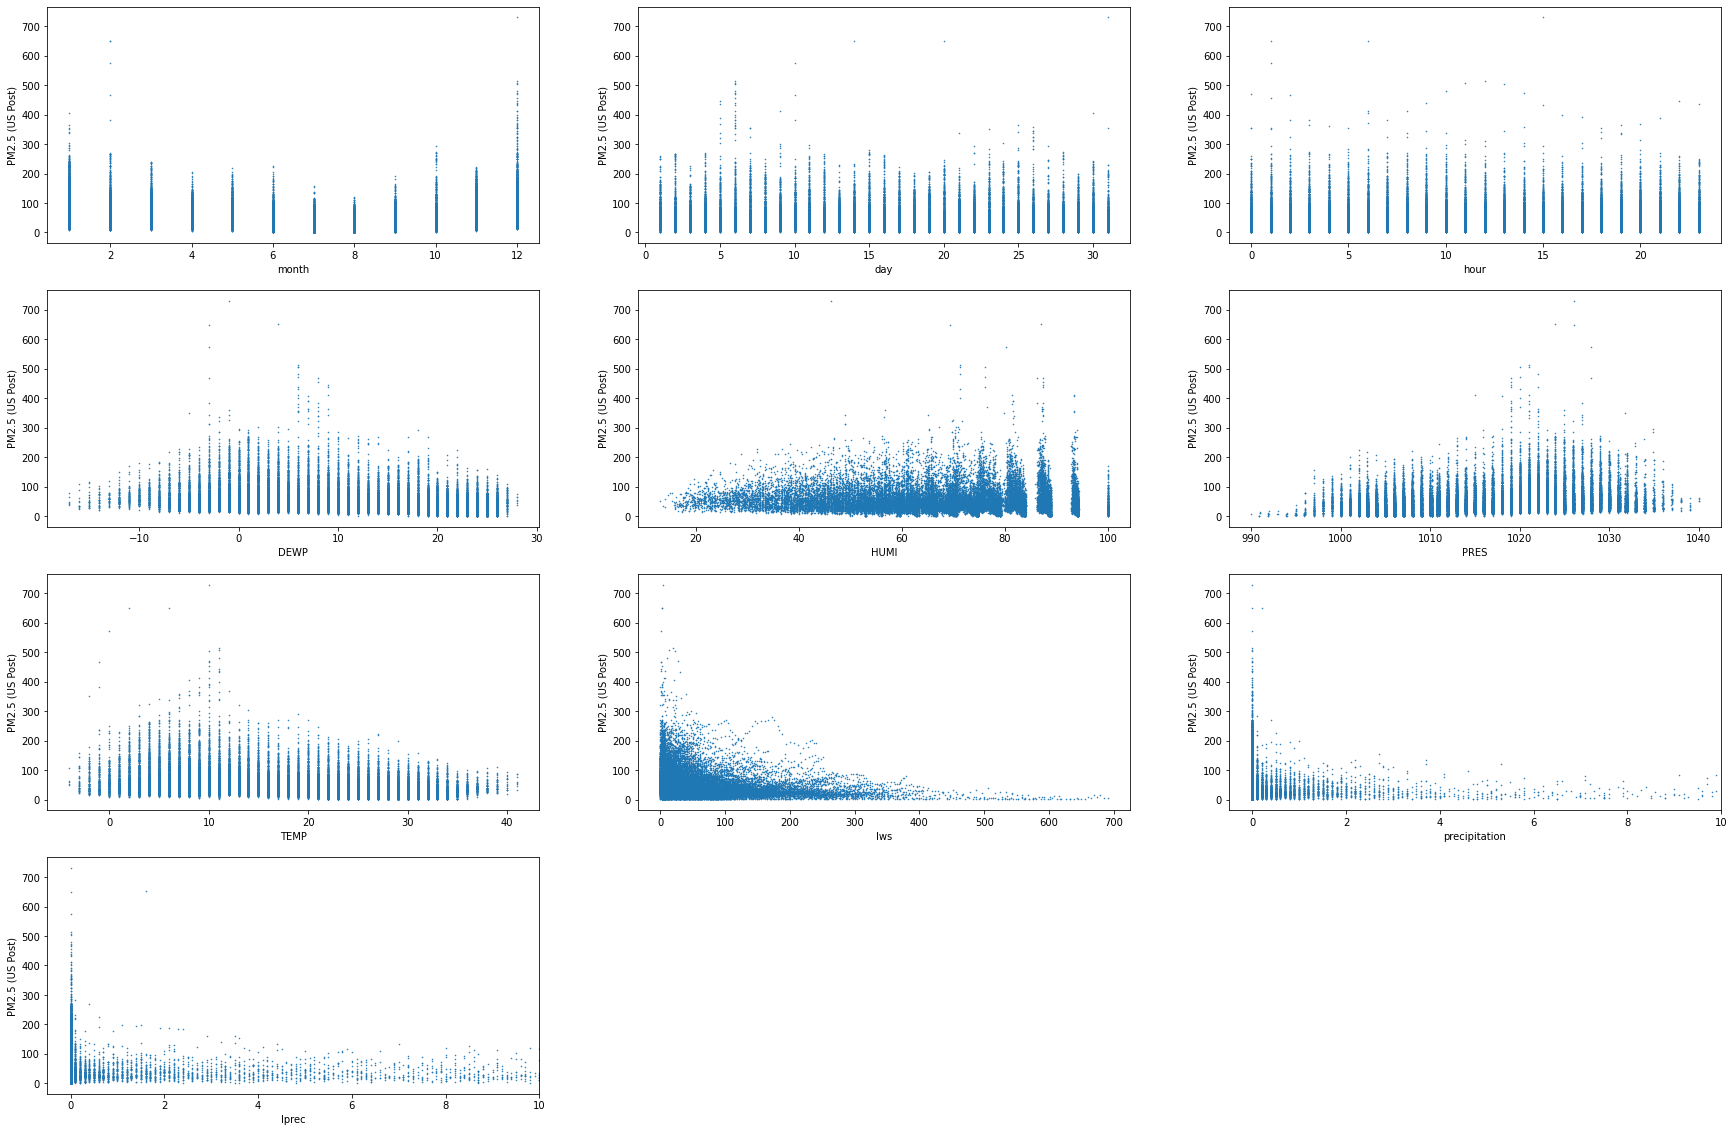

In [574]:
to_study = ['month', 
            'day', 
            'hour',
            'DEWP', 
            'HUMI',
            'PRES', 
            'TEMP',
            'Iws', 
            'precipitation', 
            'Iprec']
fig = plt.figure(figsize=(30,20))
fig_count = 1
for cur_feature in to_study:
  if 'prec' in cur_feature:
    ax = fig.add_subplot(4,3,fig_count)
    plt.scatter(dataset.loc[:,cur_feature], dataset.loc[:,'PM_US Post'], s=0.3, label=(cur_feature))
    #plt.legend()
    plt.gca().set(xlabel=cur_feature, ylabel='PM2.5 (US Post)')
    plt.gca().set_xlim(-.5,10.)
  else:
    ax = fig.add_subplot(4,3,fig_count)
    plt.scatter(dataset.loc[:,cur_feature], dataset.loc[:,'PM_US Post'], s=0.3, label=(cur_feature))
    #plt.legend()
    plt.gca().set(xlabel=cur_feature, ylabel='PM2.5 (US Post)')
  fig_count+=1
plt.show()

Some takeaways from this plot is that there are strong correlations between PM2.5 and humidity (Beijing mostly), dew point, pressure, and the month. Also, there are correlations with windspeed and precipitation, but the occurance of extreme values are rare and may not be a reliable metric to model on. It is safe to say however that precipitation or high wind speeds tend correlate to lower PM2.5.

## Data Preprocessing


### Imputing

Remove the NaN values and handle large periods of time without any PM data. For now, impute the NaN values with the mean PM2.5 value of the US Post. The US Post is the most ubiquitous PM2.5 column in the dataset and therefore will be used. This strategy may be improved on in the future by imputing from the other posts instead of using the mean. 

In [575]:
from sklearn.impute import SimpleImputer
print("NaN count before and after imputing PM2.5: ")
print(np.count_nonzero(np.isnan(y['PM_US Post'].astype(np.float))))
y_prep = np.vstack(y['PM_US Post'])
US_post_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
US_post_imputer.fit(y_prep)
y['PM_US Post'] = US_post_imputer.transform(y_prep)
print(np.count_nonzero(np.isnan(y['PM_US Post'].astype(np.float))))

NaN count before and after imputing PM2.5: 
18545
0


There are some values that need imputing in the set of features:
*    Precipitiation (Precipitation and lprec): Use the median to replace NaN values. Mean is also acceptable, but has little to no affect on final outcome.
*    Wind direction (cbwd): Use previously known cbwd entry (forward-fill). This is categorical and will have to be encoded before manipulation.
*    Other values with NAN (DEWP, HUMI, PRES, TEMP, LWS): Use local average of neighbors (linear interpolation) and is numerical so it does not need to be encoded.

Precipitation:

In [576]:
print("NaN count before and after imputing precipitation: ")
print(np.count_nonzero(np.isnan(X[:,-2:].astype(np.float))))
prec_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
prec_imputer.fit(X[:,-2:])
X[:,-2:] = prec_imputer.transform(X[:,-2:])
print(np.count_nonzero(np.isnan(X[:,-2:].astype(np.float))))

NaN count before and after imputing precipitation: 
8018
0


Other features (not wind direction):

In [577]:
from pandas.core.frame import DataFrame
print("NaN count before and after imputing other features: ")
print(np.count_nonzero(np.isnan(X[:,[-8,-7,-6,-5,-3]].astype(np.float))))
for col in [-8,-7,-6,-5,-3]:
  df = DataFrame(data = X[:,col])
  df = df.iloc[:, -1].astype(float).interpolate(method='linear')
  X[:,col] = df
print(np.count_nonzero(np.isnan(X[:,[-8,-7,-6,-5,-3]].astype(np.float))))

NaN count before and after imputing other features: 
79
0


Wind direction:

In [578]:
winds = X[:,-4]
new_cols = np.zeros((len(winds),5))
winds = np.vstack(winds)
new_cols = np.concatenate((winds, new_cols),1)


new_cols[new_cols[:,0] == 'NE'] = ['NE', 1., 0., 0., 0., 0.]
new_cols[new_cols[:,0] == 'NW'] = ['NW', 0., 1., 0., 0., 0.]
new_cols[new_cols[:,0] == 'SW'] = ['SW', 0., 0., 1., 0., 0.]
new_cols[new_cols[:,0] == 'SE'] = ['SE', 0., 0., 0., 1., 0.]
new_cols[new_cols[:,0] == 'cv'] = ['cv', 0., 0., 0., 0., 1.]
new_cols[new_cols[:,0] == 'nan'] = ['nan', np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]


print("NaN count before and after imputing wind direction: ")
print(np.count_nonzero(np.isnan(new_cols[:,1].astype(np.float))))
df = DataFrame(data = new_cols)
df = df.iloc[:, 1:].astype(float).fillna(method='ffill')
final = df.values
print(np.count_nonzero(np.isnan(final[:,1].astype(np.float))))
X = np.concatenate((X,final),1)

NaN count before and after imputing wind direction: 
12
0


Last, I will clean out the variables that may not be helpful like the string value of the wind direction and event number (since this will not be useful in prediction).

In [579]:
X_final = X[:,[1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18]]
features_final = ['year',
                  'month',
                  'day',
                  'hour',
                  'season',
                  'DEWP',
                  'HUMI',
                  'PRES',
                  'TEMP',
                  'lws',
                  'precipitation',
                  'lprec',
                  'NE',
                  'NW',
                  'SW',
                  'SE',
                  'cv']
y_final = np.vstack(y['PM_US Post'])

## Splitting the dataset into the Training set and Test set

Split the data so 80% is used for training and 20% for testing.

In [580]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y['PM_US Post'], test_size = 0.2, random_state = 0)

Next, I will train several models. Note that the Random Forest Regression is best, so the other models are hidden and put inside a condition to only run it if set True. In other words, the final product is Random Forest but feel free to take a look at my other models, which are suboptimal in comparison.

## Training the Multiple Linear Regression model on the Training set

In [581]:
if try_all_regressions:
  from sklearn.linear_model import LinearRegression
  regressor = LinearRegression()
  regressor.fit(X_train, y_train)

### Predicting the Test set results

In [582]:
if try_all_regressions:
  y_pred = regressor.predict(X_test)
  np.set_printoptions(precision=2)
  print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

### Evaluating the Model Performance

In [583]:
if try_all_regressions:
  from sklearn.metrics import r2_score
  r2_score(y_test, y_pred)

## Training Polynomial Regression

In [584]:
if try_all_regressions:
  from sklearn.preprocessing import PolynomialFeatures
  poly_reg = PolynomialFeatures(degree = 4)
  X_poly = poly_reg.fit_transform(X_train)
  regressor = LinearRegression()
  regressor.fit(X_poly, y_train)

### Predicting the Test set results

In [585]:
if try_all_regressions:
  y_pred = regressor.predict(poly_reg.transform(X_test))
  np.set_printoptions(precision=2)
  print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

### Evaluating the Model Performance

In [586]:
if try_all_regressions:
  from sklearn.metrics import r2_score
  r2_score(y_test, y_pred)

## Training SVR

First I need to feature scale

In [587]:
if try_all_regressions:
  from sklearn.preprocessing import StandardScaler
  sc_X = StandardScaler()
  sc_y = StandardScaler()
  X_train_tran = sc_X.fit_transform(X_train)
  y_train_tran = sc_y.fit_transform(y_train)

Now Train

In [588]:
if try_all_regressions:
  from sklearn.svm import SVR
  regressor = SVR(kernel = 'rbf')
  regressor.fit(X_train_tran, y_train_tran)

### Predicting the test set results

In [589]:
if try_all_regressions:
  y_pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_test)))
  np.set_printoptions(precision=2)
  print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

Evaluating the model performance

In [590]:
if try_all_regressions:
  from sklearn.metrics import r2_score
  r2_score(y_test, y_pred)

## Training Random Forest Regression

Train the Random Forest Regressor. Several options of estimators are tried with 100 being the best performance for the amount of time it takes to run. More estimators give slightly better performance with much longer run time.

In [591]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

### Predicting the test set results

Predict the PM2.5 values and print a comparison next to the actual values.

In [592]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[40.86 41.  ]
 [41.   41.  ]
 [41.89 37.  ]
 ...
 [74.04 70.  ]
 [41.   41.  ]
 [48.28 47.  ]]


### Evaluating the model performance

Print the R^2 score for the test set.

In [593]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8233172185133363

## Using the Model

The random forest predicts the PM levels with the best R^2 score. This can then be used in the future to predict the PM levels based on the variety of features. What is left is analyzing the features some more and to define a baseline as to what qualifies a "high PM2.5" day.

### Analyzing the impact of the variables

Below is a permutation importance test that varies the features independently and observes the impact on the score of the regression. The higher the impact, the more important the feature is to the model. I will then compare this test to my intuition as seen earlier during the general plotting.

In [594]:
!pip install eli5

In [595]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(regressor, random_state=0).fit(X_test, y_test.reshape(len(y_test),1))
print(eli5.format_as_text(eli5.explain_weights(perm, feature_names=features_final)))

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.6672 ± 0.0139  year
0.3503 ± 0.0188  month
0.3030 ± 0.0187  DEWP
0.2895 ± 0.0138  day
0.2597 ± 0.0183  season
0.2302 ± 0.0124  lws
0.1934 ± 0.0085  PRES
0.1527 ± 0.0142  TEMP
0.1227 ± 0.0044  NE
0.1029 ± 0.0129  NW
0.0780 ± 0.0119  SE
0.0719 ± 0.0063  HUMI
0.0368 ± 0.0020  hour
0.0230 ± 0.0090  SW
0.0143 ± 0.0012  lprec
0.0071 ± 0.0012  precipitation
0.0002 ± 0.0007  cv


Some interesting take aways is that it seems to matter a lot what time of the year (or what year) it is. Also, the humidity (Beijing mostly), dew point, and pressure tend to be of top importance in most cities. These findings help validate the previous intuition seen in my plotting (above) where I thought humidity, dew point, and the month would be several of the most important descriminants in our model. One suprisingly important feature is the day but there is no immediate intuition as to why and without further investigation any speculation is hypothetical.

## Determining a High PM2.5 day

The definition for a high PM2.5 day is not standardized globally, but well respected standards in the United States and Europe are defined. A daily air density of PM2.5 particles above the thresholds of 35 micrograms/m^3 and 25 micrograms/m^3 represent the standard of high PM2.5 days for the US EPA and European Union respectively. For this study, we will choose the more conservative threshold of 35 micrograms/m^3 to define a high PM2.5 day but our analysis and modelling up until this point is entirely independent of this choice.


In [596]:
mu_thres = 35
months = ['January',
          'February',
          'March',
          'April',
          'May',
          'June',
          'July',
          'August',
          'September',
          'October',
          'November',
          'December']
sample_days = [['year',
                  'month',
                  'day',
                  'hour',
                  'season',
                  'DEWP',
                  'HUMI',
                  'PRES',
                  'TEMP',
                  'lws',
                  'precipitation',
                  'lprec',
                  'NE',
                  'NW',
                  'SW',
                  'SE',
                  'cv']]
# The next two days are based on actual conditions from the 15th and 16th
# (for an arbitrary hour of the day)
sample_days.append([2021,
                    7,
                    15,
                    12,
                    2,
                    26,
                    79,
                    1020,
                    28,
                    2,
                    0.,
                    0.01,
                    1/np.sqrt(2),
                    0,
                    0,
                    1/np.sqrt(2),
                    0])
sample_days.append([2021,
                    7,
                    16,
                    12,
                    2,
                    26,
                    90,
                    1020,
                    29,
                    2,
                    0.,
                    0.03,
                    0,
                    0,
                    0,
                    1,
                    0])
# This was an example of a low PM2.5 day/hour in Beijing
sample_days.append([2010,
                    1,
                    5,
                    2,
                    4,
                    -26,
                    53,
                    1035,
                    -19,
                    209,
                    0.,
                    0.,
                    0,
                    1,
                    0,
                    0,
                    0])
for i in range(1,len(sample_days)):
  pred_PM = regressor.predict(np.array(sample_days[i]).reshape(1, -1))
  date = ' '.join([months[sample_days[i][1]],
                  str(sample_days[i][2])+',',
                  str(sample_days[i][0])])
  if pred_PM > mu_thres:
    print('I predict '+ date +' will be a HIGH PM2.5 day,')
  else:
    print('I predict '+ date +' will be a LOW PM2.5 day,')
  print("with a PM2.5 value of " + str(pred_PM[-1]))

I predict August 15, 2021 will be a LOW PM2.5 day,
with a PM2.5 value of 32.65
I predict August 16, 2021 will be a LOW PM2.5 day,
with a PM2.5 value of 28.91
I predict February 5, 2010 will be a HIGH PM2.5 day,
with a PM2.5 value of 41.0
